In [1]:
import yfinance as yf
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import numpy as np
from plotnine import ggplot, geom_line, aes,labs, theme, element_text, geom_point,geom_ribbon
import matplotlib.pyplot as plt
# This is the best implementation of Multivariate Singular Spectrum Analysis (mSSA)
# pip install git+https://github.com/AbdullahO/mSSA.git   
from mssa.mssa import mSSA


## Some Plotting Utils

In [2]:
def makeLongTimeSeriesDf(timeSeriesDataFrame):
    return timeSeriesDataFrame.reset_index().melt(id_vars = 'Date').copy()

def makeTimeSeriesPlot(title,longTimeSeriesDataFrame):
    myPlot =  (
        ggplot(longTimeSeriesDataFrame.dropna(subset=["value"]))  
        + aes(x="Date", y="value",color = "Ticker")  
        + geom_line()  # Geometric object to use for drawing
        + labs(
            x = 'Date', 
            y = 'Share Price', 
            color = 'Tickers', 
            title = title)
        + theme(axis_text_x = element_text(rotation = 90, hjust = 0), figure_size = (12,6))
    )
    return myPlot


## Pulling the Share Price Data from Yahoo Finance

In [3]:
tickers = ['GOOG', 'NVDA','META','EQX']

today = dt.date.today()
lookback = today - relativedelta(years=10)
dataLookbackFull = yf.download(tickers, start=lookback, end=today, auto_adjust=True)['Close']
dataLookbackNoNa = dataLookbackFull.dropna(subset=["EQX"]).copy()
lengthFull = len(dataLookbackFull)
lengthNoNa = len(dataLookbackNoNa)
lastNaNum = lengthFull - lengthNoNa
title = "Time Series Plot Showing Closing Share Price for the lookback period before Data Imputation"
plotComplete = makeTimeSeriesPlot(title,makeLongTimeSeriesDf(dataLookbackFull))
dataLookbackFull.head() # Tickers are pulled in alphabetical order

[*********************100%%**********************]  4 of 4 completed


Ticker,EQX,GOOG,META,NVDA
Date,,,,
2014-03-11,NaN,29.887724,70.025703,4.328396
2014-03-12,NaN,30.069792,70.804871,4.340243
2014-03-13,NaN,29.615494,68.757050,4.202833
2014-03-14,NaN,29.210512,67.648224,4.221786
2014-03-17,NaN,29.691210,68.667145,4.221786


## Some comments on the Data Imputation

We can need to take into account the correlations between the other assets in our portfolio when we do imputation i.e. Multivariate time series imputation. One could use Vector Auto Regressive Models to achieve this. This is a regression that fits the entire time series and considers cross correlations. In order to use VAR models, we would need to make all our time series stationery before we could implement them. Hesitant to use a recurrent neural network (or any neural network) given the their black box nature. Spatio-Temporal factoring methods could be good here. There is a good Python implementaion of Multivariate Singular Spectrum Analysis (mSSA). The spatial component is the correlation across all the time series. Hoping that mSSA can capture how the correlation changes over time - markets tend to be more correlated during periods of market stress. Another pro for mSSA is that it requires less prep time to make it work - VAR method must ensure that time series is an autoregressive process via transformations. From the paper I read, the mSSA method is robust, easy to implement and effective. Also it apparenty outperformed DeepAR, but I need to verify this for myself. 

## The Multivariate Singular Spectrum Analysis Technique

In [4]:
model = mSSA(fill_in_missing = True)
# Note that when it comes to data imputation, you don't need to specify a time structure as long as all every row
# corresponds to the same observation point. Only care about the relative structure. We can drop the index. 
model.update_model(dataLookbackFull.reset_index(drop=True))
predictions = np.ones((lengthFull,3))
for ix in range(lengthFull):
    predictions[ix,:] = model.predict('EQX',ix,confidence=99).values
 
predictions = pd.DataFrame(predictions, columns=['EQX_Predicted', 'Lower_Conf','Upper_Conf'],
                            index=dataLookbackFull.index)
predictions.columns.name = 'Ticker'
longPredictions = makeLongTimeSeriesDf(predictions)
df = makeLongTimeSeriesDf(dataLookbackFull)
longActual = df[df.Ticker == 'EQX'].dropna()

caption = """\
This graphic illustrates the efficacy of the Multivariate Singular Spectrum Analysis technique. For the portion of the market where we did not impute any data, the predicted EQX
price agrees with the actual EQX share price. Moreover, the 99 percent confidence interval is tight around the actual values, making us more certain that the algorithim is work-
ing satisfactorily. Note that the correlation with the rest of the portfolio is maintained in the imputed portion. This is great as the underlying market factors that influence the rest of
our portfolio also impact EQX. This means that our imputed values will be similar not only to the actual values of EQX, but also the rest of the portfolio. I'm happy with the results!
"""

plotEQX = (
    ggplot(data=predictions.reset_index()) # we can override this data later
    +geom_line(aes(x = 'Date', y = 'value',color = 'Ticker'), data=longPredictions)
    +geom_point(aes(x = 'Date', y = 'value',color = 'Ticker'),alpha = 0.5, size = 0.1, data=longActual)
    +geom_ribbon(aes(x = 'Date',ymin='Lower_Conf', ymax="Upper_Conf"),alpha = 0.5, fill="#0294a55e")
    + labs(
        x = 'Date', 
        y = 'Share Price', 
        color = 'Tickers', 
        title = "The Share Price for EQX with the Spatio-Temporal Imputed Values",
        subtitle = 'The Multivariate Singular Spectrum Analysis Algorithm captures the drift, and the volatility regime shift implied by the other assets in the portfolio', 
        caption = caption)
+ theme(axis_text_x = element_text(rotation = 90, hjust = 0), 
        figure_size = (12,7),
        # left justify the caption and have one line of space between it and
        # the x-axis label
        plot_caption=element_text(ha="left", margin={"t": 1, "units": "lines"}))
)

# Replace the missing values with the predicted values 
dataLookbackFull.iloc[:lastNaNum,0] = predictions.iloc[:lastNaNum,0] 

## Plots Showing the Share Price before and after Data Imputation

### Before Imputation

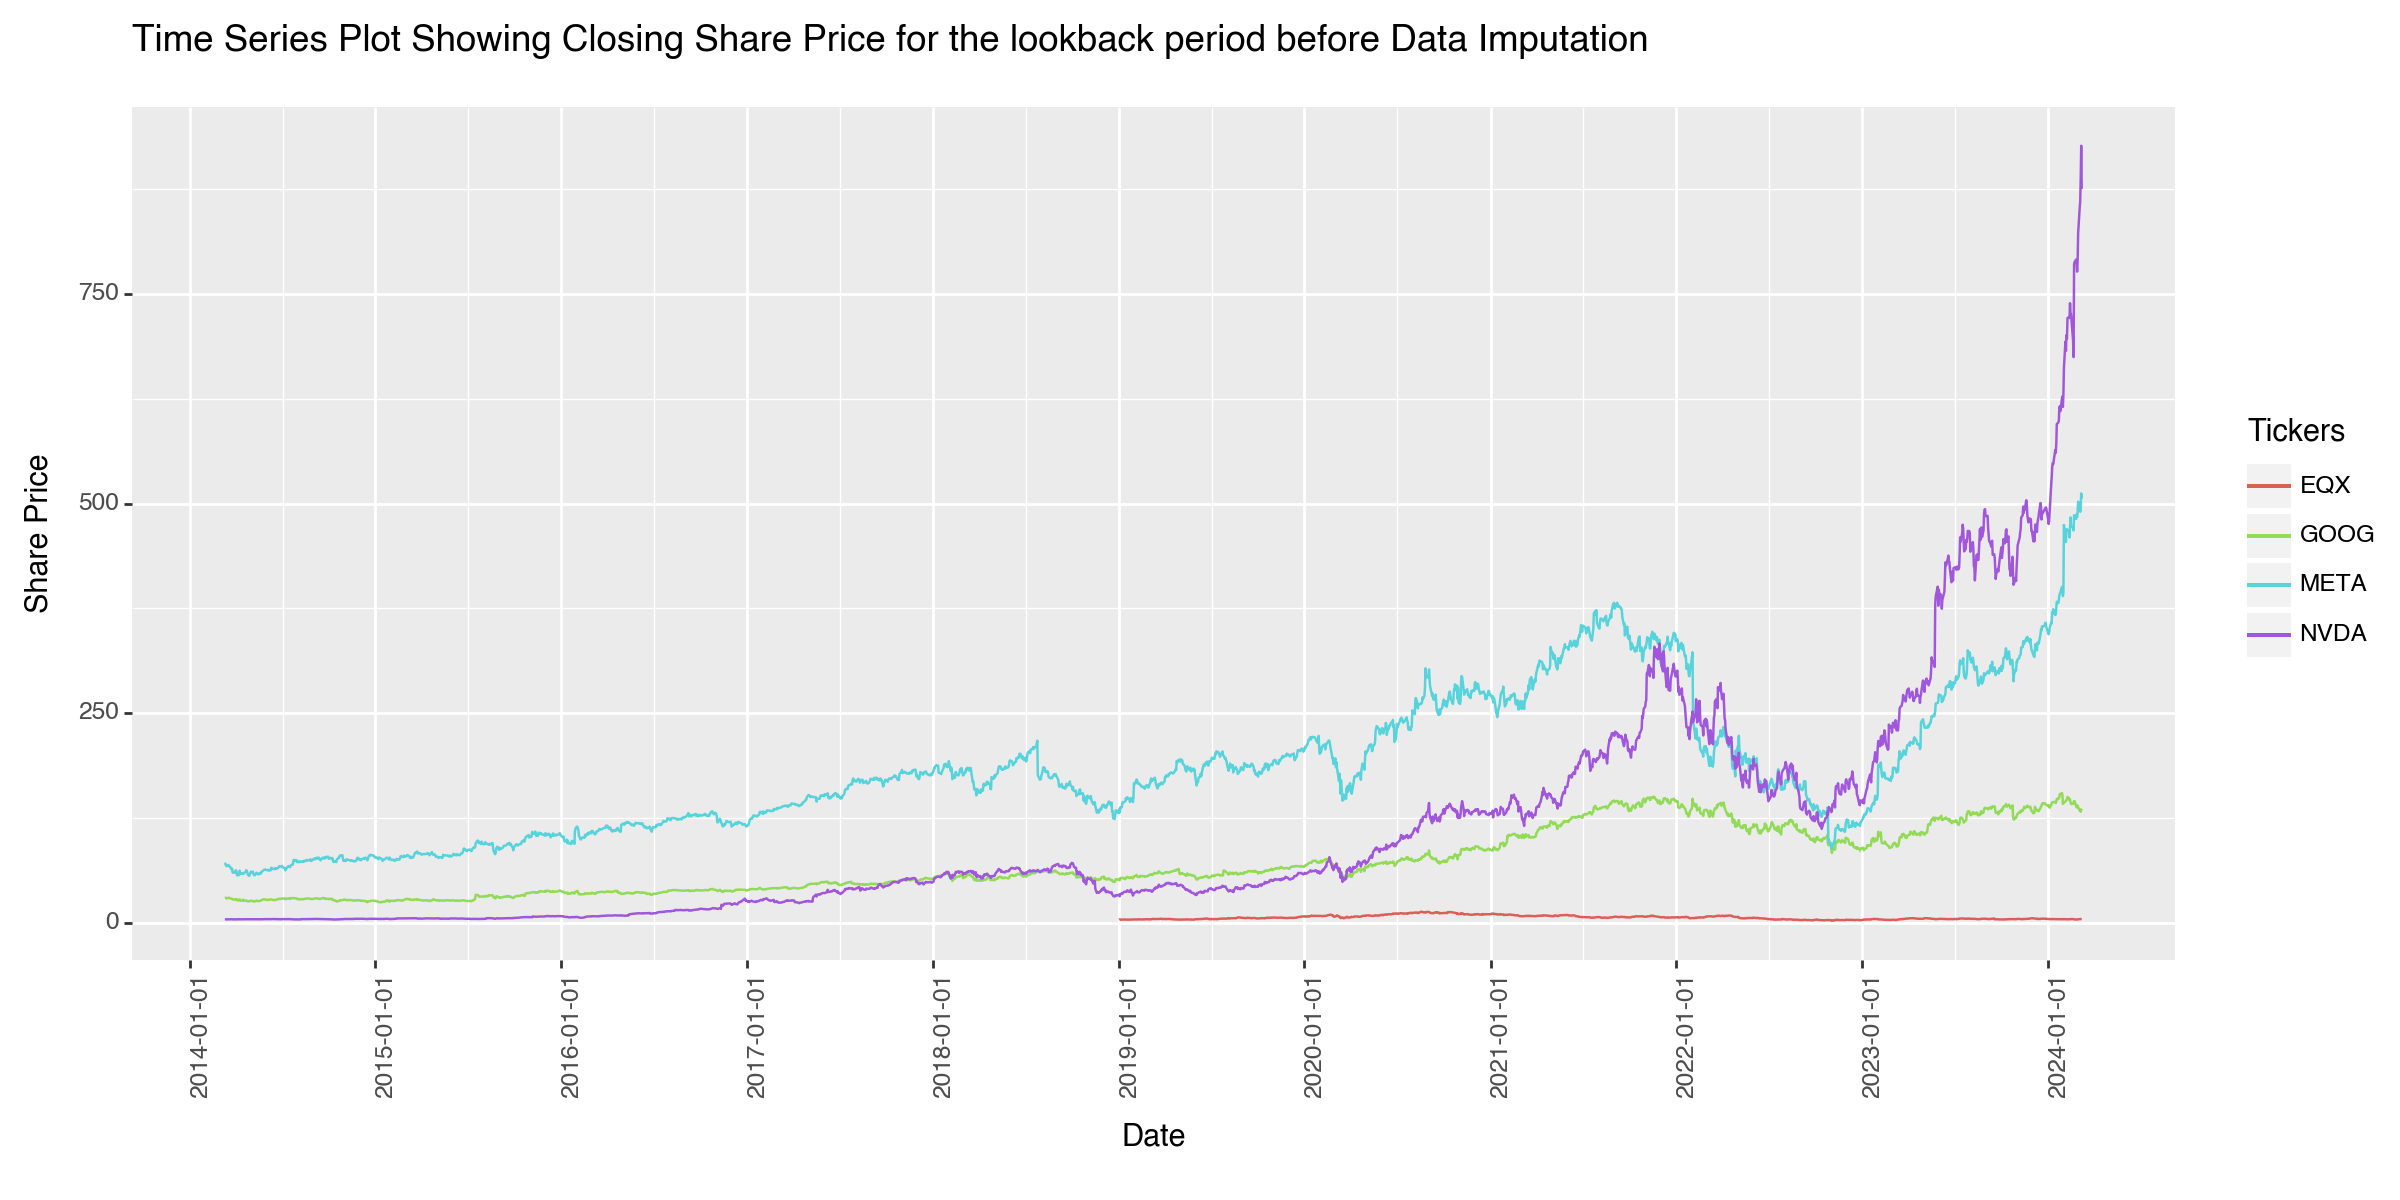

<Figure Size: (1200 x 600)>

In [5]:
plotComplete

### After Imputation

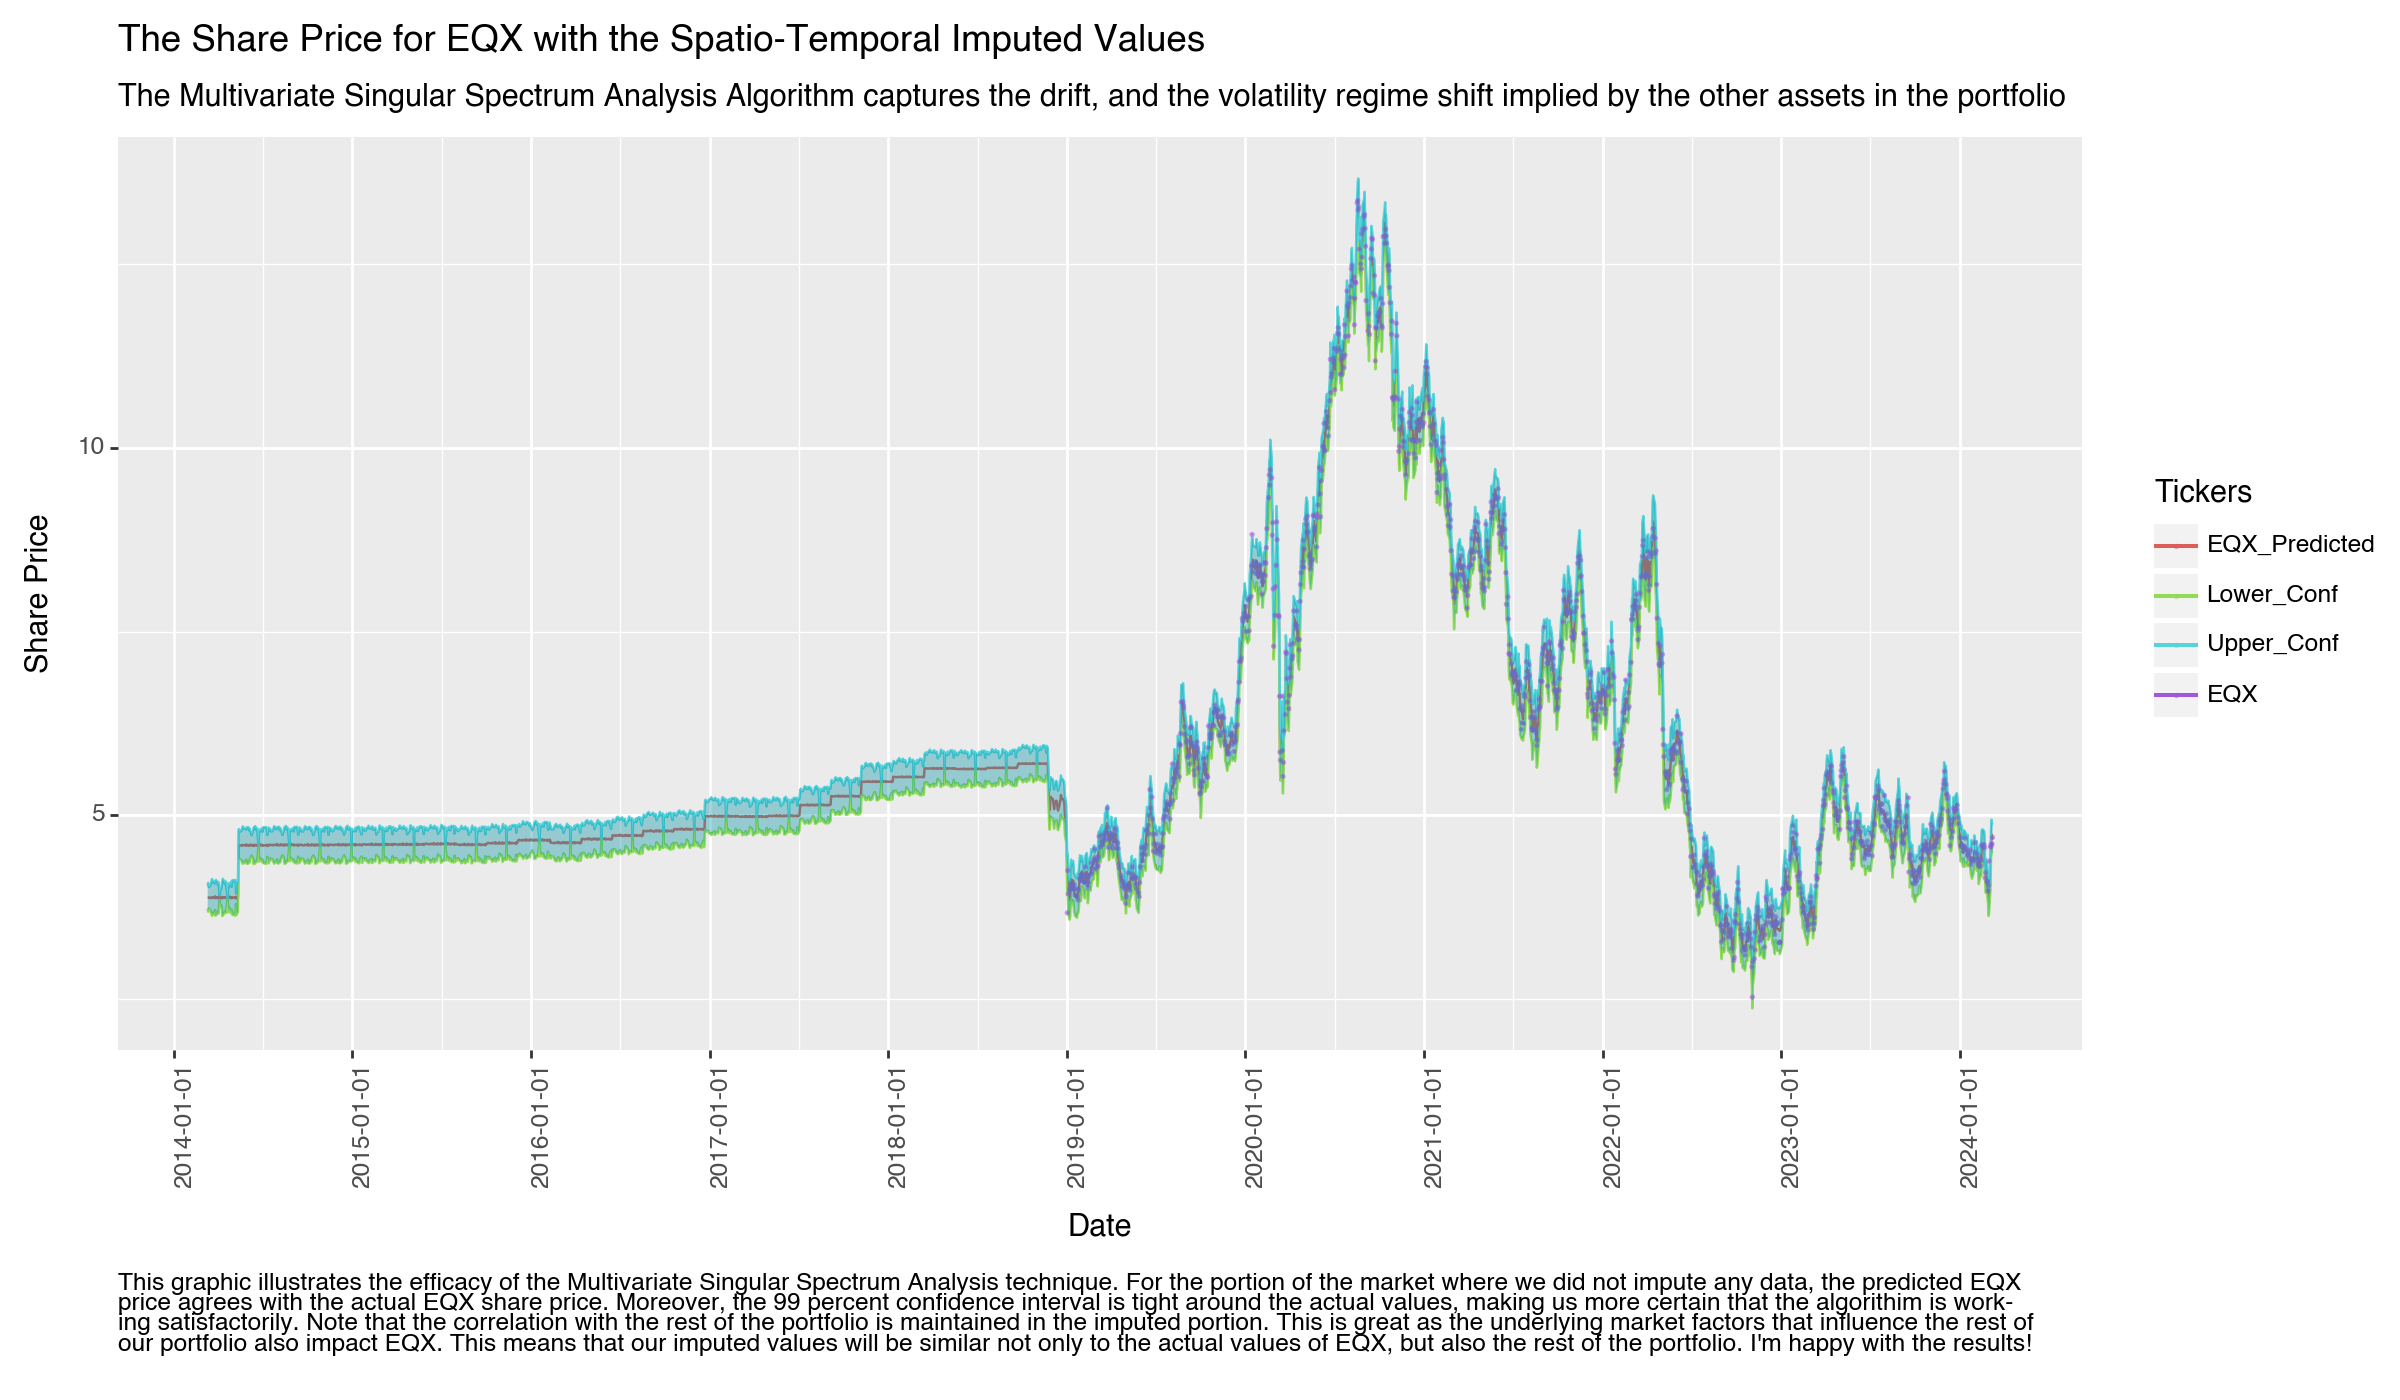

<Figure Size: (1200 x 700)>

In [6]:
plotEQX

## Historical Value at Risk (VaR)

In [7]:
dailyReturns = dataLookbackFull.pct_change().dropna()
dailyReturns

Ticker,EQX,GOOG,META,NVDA
Date,,,,
2014-03-12,-0.000304,0.006092,0.011127,0.002737
2014-03-13,-0.001201,-0.015108,-0.028922,-0.031660
2014-03-14,-0.001013,-0.013675,-0.016127,0.004510
2014-03-17,0.000255,0.016456,0.015062,0.000000
2014-03-18,-0.001125,0.016072,0.006546,0.023569
...,...,...,...,...
2024-03-04,0.045662,-0.028100,-0.008182,0.035951
2024-03-05,-0.002183,-0.003130,-0.015998,0.008576
2024-03-06,0.008753,-0.009119,0.011974,0.031827


The component VaR shows the reduction of the portfolio value-at-risk resulting from removal of a position. The sum of component VaR of the shares in the portfolio equals the portfolio diversified VaR

In [8]:
def computeRisk(numOfSimulations, numOfShares, currentSharePrice, dailyReturns,alpha,holdingPeriod,tickers):
    pnl = np.ones((numOfSimulations,1))   
    numOfTickers = len(tickers)

    holdingPrices = np.ones((numOfSimulations,numOfTickers))
    intialPortfolioValue =  currentSharePrice.T @ numOfShares
    # Making the assumption that we will not rebalance our portfolio during the holding period 
    # The number of shares will remain constant
    for sim in range(numOfSimulations):
        cumulativeReturn = np.cumprod(1+dailyReturns.
                                      sample(n=holdingPeriod, replace=True).values, axis = 0)[-1,:]
        holdingPrices[sim:sim+1,:] = cumulativeReturn * currentSharePrice.T

    pnl = holdingPrices @ numOfShares - intialPortfolioValue
    pnl = np.sort(pnl,axis=0)
    valueAtRiskIndex = int(np.floor(numOfSimulations*alpha))
    portfolioValueAtRisk = pnl[valueAtRiskIndex][0]
    portfolioExpectedShortFall = np.mean(pnl[:valueAtRiskIndex]) # losses exceeding value at Risk 

    df = pd.DataFrame(holdingPrices, columns=dailyReturns.columns)
    compVar = np.ones(numOfTickers)
    for ix in range(numOfTickers):
        compCurrentSharePrice = np.delete(currentSharePrice,ix)
        compNumOfShares = np.delete(numOfShares,ix)
        compIntialPortfolioValue =  compCurrentSharePrice.T @ compNumOfShares
        compHoldingPrices = df.drop(columns = tickers[ix], inplace=False)
        compPnl = compHoldingPrices @ compNumOfShares - compIntialPortfolioValue
        compPnl = np.sort(compPnl, axis = 0)
        compVar[ix] = compPnl[valueAtRiskIndex]

    compVar =  portfolioValueAtRisk - compVar 
    return portfolioValueAtRisk, portfolioExpectedShortFall, compVar,pnl

tickers = ['EQX', 'GOOG', 'META', 'NVDA']
tickersLen = len(tickers)
weights = np.ones((tickersLen,1))
weights[0] = 0.13
weights[1] = 0.45
weights[2] = 0.32
weights[3] = 0.1

numOfSimulations = 200000
holdingPeriod = 30
alpha = 0.01
intialEndowmnet = 500000*np.ones((tickersLen,1))
currentSharePrice = (dataLookbackFull.iloc[-1,:].values*np.ones((1,tickersLen))).T
cashAllocation = intialEndowmnet * weights
numOfShares = cashAllocation / currentSharePrice
metrics = computeRisk(numOfSimulations,
                       numOfShares, 
                       currentSharePrice, 
                       dailyReturns,
                       alpha,holdingPeriod,
                       tickers)
portfolioValueAtRisk, portfolioExpectedShortFall,componentValueAtRisk, pnl = metrics



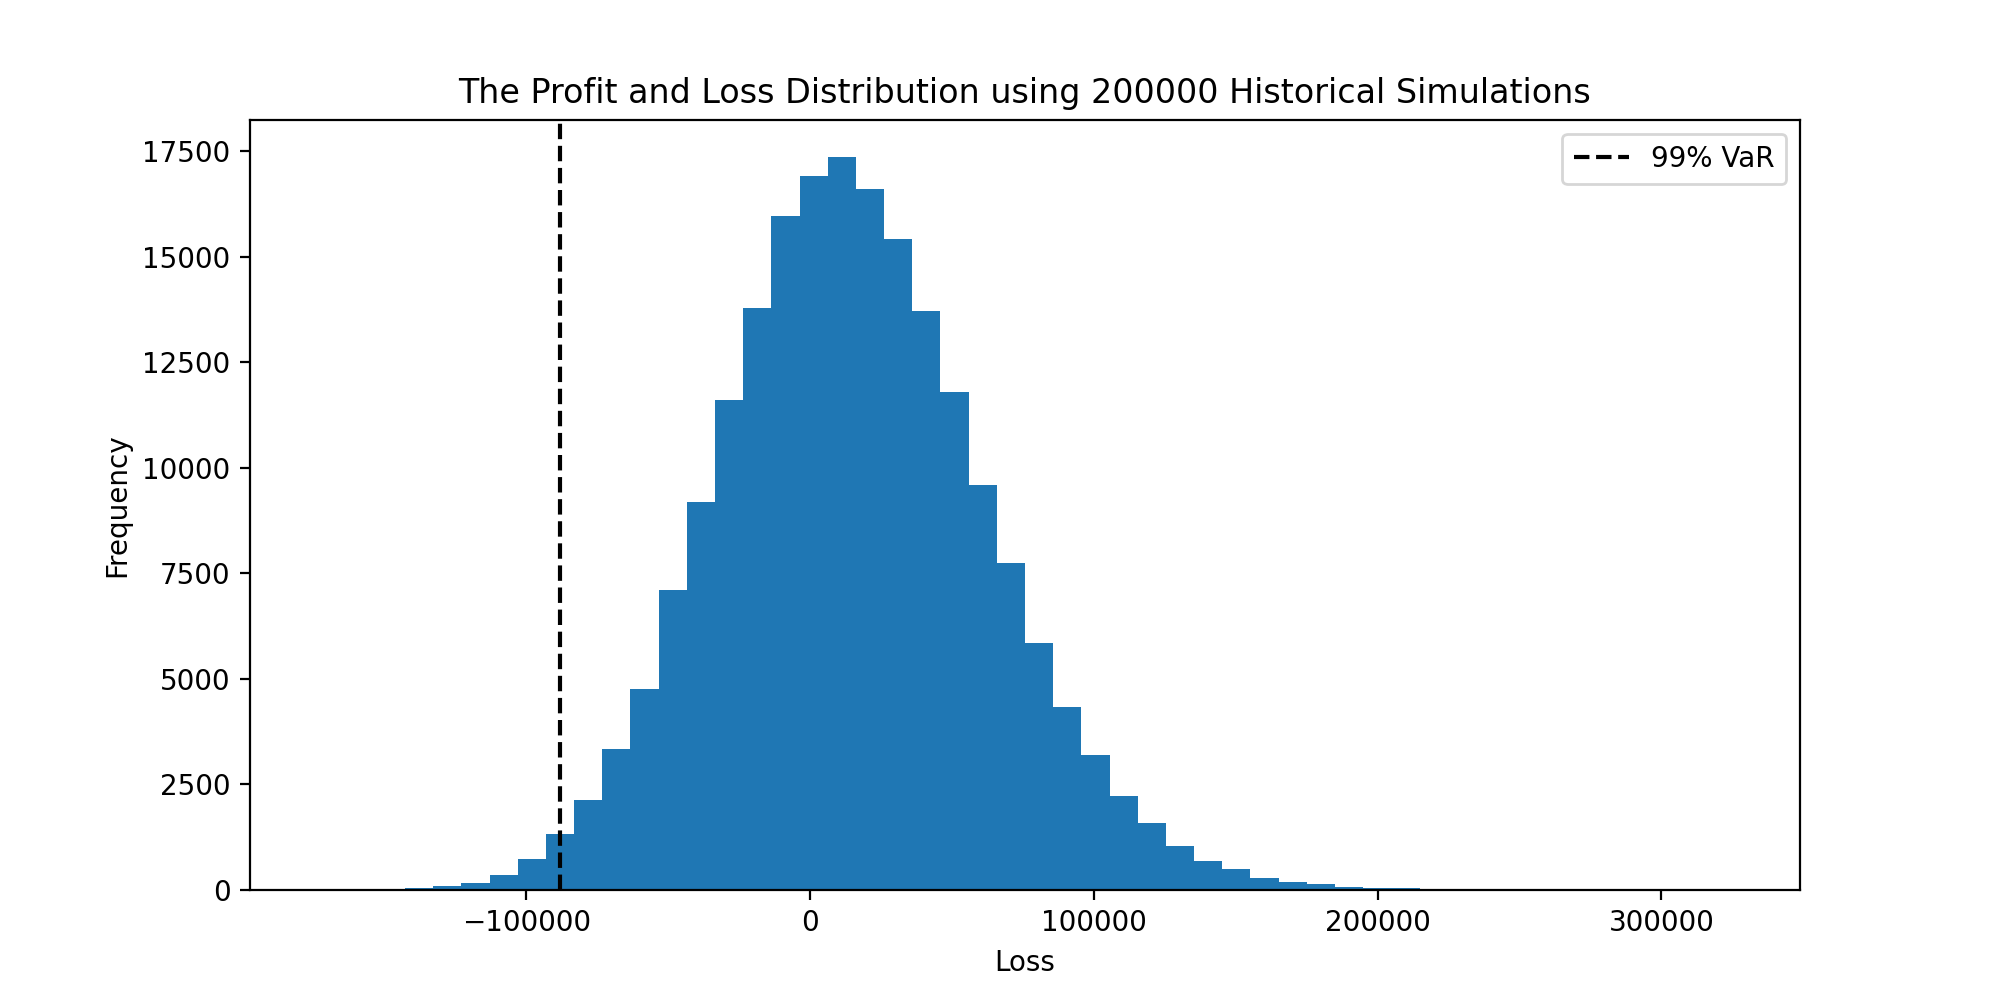

In [9]:
plt.figure(figsize=(10,5))
plt.hist(list(pnl[:,0]),bins = 50)
plt.title(f'The Profit and Loss Distribution using {numOfSimulations} Historical Simulations')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.axvline(x=portfolioValueAtRisk, label = '99% VaR',color = 'k', linestyle = '--')
plt.legend()
plt.show()

In [10]:
portfolioValueAtRisk

-88163.48389822012

In [11]:
componentValueAtRisk

array([ -4329.42249481, -32948.88603112, -31415.92501229,  -7859.89990751])

In [12]:
np.sum(componentValueAtRisk) 
# This should be lower than the portfolio VaR as it takes into consideration diversification

-76554.13344572438

## Monte-Carlo Value at Risk

In [13]:
# Mixing it up, using log returns, we can show using Taylor expansions, the results 
# should be quite similar
logDailyReturns = np.log(dataLookbackFull).diff().dropna()
logDailyReturns

Ticker,EQX,GOOG,META,NVDA
Date,,,,
2014-03-12,-0.000304,0.006073,0.011065,0.002733
2014-03-13,-0.001202,-0.015223,-0.029349,-0.032172
2014-03-14,-0.001014,-0.013769,-0.016258,0.004499
2014-03-17,0.000255,0.016322,0.014950,0.000000
2014-03-18,-0.001126,0.015945,0.006525,0.023296
...,...,...,...,...
2024-03-04,0.044650,-0.028502,-0.008216,0.035320
2024-03-05,-0.002186,-0.003135,-0.016127,0.008540
2024-03-06,0.008715,-0.009161,0.011903,0.031331


In [14]:

# Using a geometric Brownian Motion for the dynamics of the Portfolio
# Will use the realised market data to calibrate the parameters


# Annualise the drift and volatility
drift = 252*(np.ones((1,4))*logDailyReturns.mean().values).T
volatility = np.sqrt(252)*(np.ones((1,4))*logDailyReturns.std().values).T
correlation = logDailyReturns.corr().values
holdingPeriod = 30 
terminalTime = 1/12 # 1 month
timeInterval = terminalTime/holdingPeriod # Daily Intervals 
numOfSimulations = 200000
alpha = 0.01
pnl = np.ones(numOfSimulations)

# This is the lower Cholesky Decomposition 
L = np.linalg.cholesky(correlation)

for ix in range(numOfSimulations):
    correlatedNumbers = L @ np.random.normal(0,1,(len(tickers),holdingPeriod))
    sharePricePaths = currentSharePrice * np.exp(
                                                 np.cumsum((drift - 0.5*volatility**2)*timeInterval 
                                                  +volatility* np.sqrt(timeInterval) * correlatedNumbers,axis =1)
                                                )
    priceEndHolding = sharePricePaths[:,-1:]
    # Assuming that will not rebalance during the Holding period
    # i.e. the number of shares will remain the same
    pnl[ix] =  numOfShares.T @ (priceEndHolding - currentSharePrice)

pnl = np.sort(pnl)
valueAtRiskIndex = int(np.floor(numOfSimulations*alpha))
portfolioValueAtRisk = pnl[valueAtRiskIndex]
portfolioExpectedShortFall = np.mean(pnl[:valueAtRiskIndex]) # losses exceeding value at Risk 


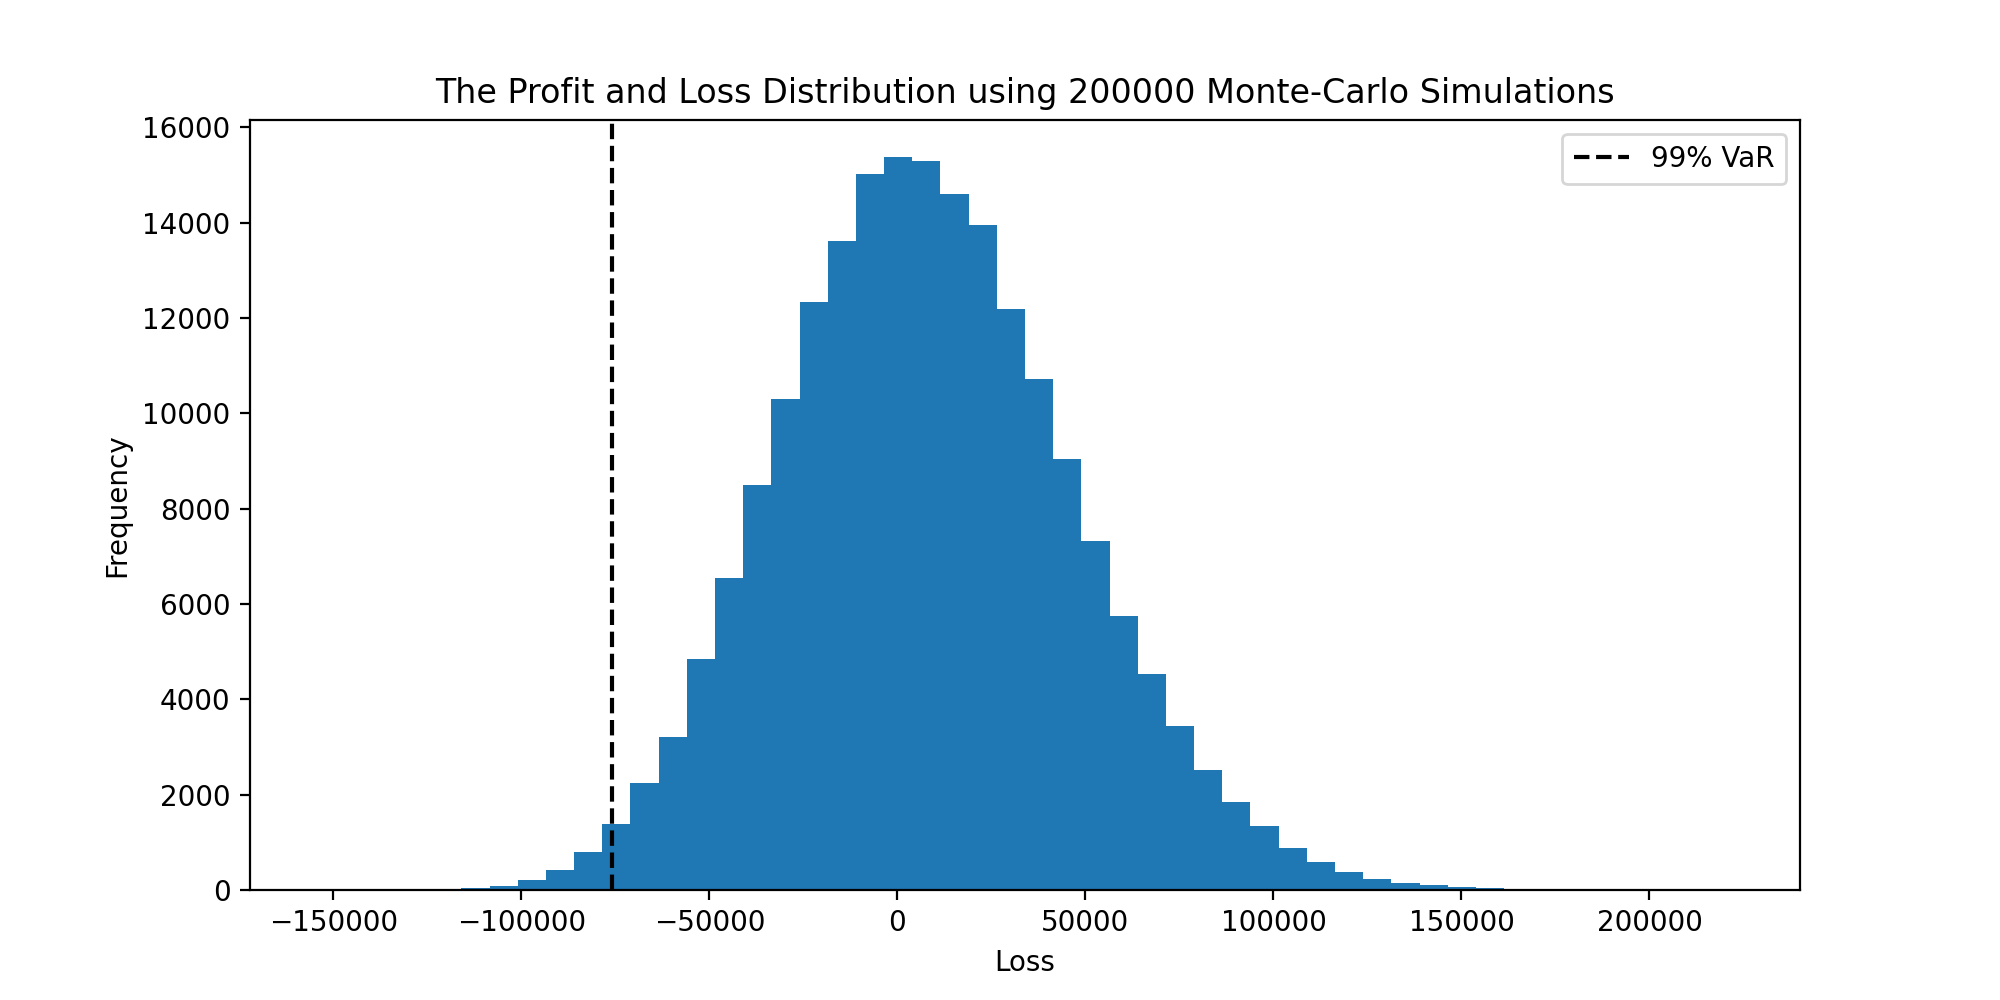

In [15]:
plt.figure(figsize=(10,5))
plt.hist(pnl,bins = 50)
plt.title(f'The Profit and Loss Distribution using {numOfSimulations} Monte-Carlo Simulations')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.axvline(x=portfolioValueAtRisk, label = '99% VaR',color = 'k', linestyle = '--')
plt.legend()
plt.show()

In [16]:
portfolioValueAtRisk

-75919.83323977959

In [17]:
portfolioExpectedShortFall

-86387.06824526603